In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.cluster import KMeans
%matplotlib inline
# import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from datetime import datetime, timedelta, date
from __future__ import division

In [67]:
df=pd.read_csv('OnlineRetail.csv',encoding = 'unicode_escape'
              )

In [68]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [69]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [70]:
df['InvoiceDate'].describe()

C:\Users\Rachit Pahwa\AppData\Local\Temp\ipykernel_15752\809870227.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [71]:
df.shape

(541909, 8)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [73]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [74]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [75]:
df['Quantity'].min()

-80995

In [76]:
df[['StockCode','Description','Country']].value_counts()

StockCode  Description                         Country       
85123A     WHITE HANGING HEART T-LIGHT HOLDER  United Kingdom    2204
85099B     JUMBO BAG RED RETROSPOT             United Kingdom    2001
22423      REGENCY CAKESTAND 3 TIER            United Kingdom    1859
47566      PARTY BUNTING                       United Kingdom    1634
20725      LUNCH BAG RED RETROSPOT             United Kingdom    1460
                                                                 ... 
22674      FRENCH TOILET SIGN BLUE METAL       Germany              1
22675      FRENCH KITCHEN SIGN BLUE METAL      Finland              1
                                               Poland               1
                                               Switzerland          1
m          Manual                              United Kingdom       1
Length: 20755, dtype: int64

In [77]:
df['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

Model should hit the algorithm so we will be considering UK more into effective as most of population of data is from there. Our model shouldn't get biased from country like Saudi Arabia.

So we are selecting data for just one country

In [78]:
df_uk = df.query("Country == 'United Kingdom'").reset_index(drop=True)

In [79]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [80]:
df_user = pd.DataFrame(df['CustomerID'].unique())
df_user.columns = ['CustomerID']

In [81]:
df_user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


We're now trying to group by with customer ID as our algorithm should not count 2 or more customer ID if they ordered multiple times. To make it unique we're doing it. And also we'll take care of recency while doing it.

In [82]:
df_max_purchase = df_uk.groupby('CustomerID').InvoiceDate.max().reset_index()

In [83]:
df_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [84]:
df_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [85]:
df_uk.loc[(df_uk['CustomerID']==12820.0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
55503,541283,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2011-01-17 12:34:00,0.55,12820.0,United Kingdom
55504,541283,84992,72 SWEETHEART FAIRY CAKE CASES,24,2011-01-17 12:34:00,0.55,12820.0,United Kingdom
55505,541283,21733,RED HANGING HEART T-LIGHT HOLDER,6,2011-01-17 12:34:00,2.95,12820.0,United Kingdom
55506,541283,21985,PACK OF 12 HEARTS DESIGN TISSUES,24,2011-01-17 12:34:00,0.29,12820.0,United Kingdom
55507,541283,22195,LARGE HEART MEASURING SPOONS,12,2011-01-17 12:34:00,1.65,12820.0,United Kingdom
55508,541283,22196,SMALL HEART MEASURING SPOONS,12,2011-01-17 12:34:00,0.85,12820.0,United Kingdom
55509,541283,22435,SET OF 9 HEART SHAPED BALLOONS,12,2011-01-17 12:34:00,1.25,12820.0,United Kingdom
55510,541283,22804,CANDLEHOLDER PINK HANGING HEART,6,2011-01-17 12:34:00,2.95,12820.0,United Kingdom
55511,541283,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2011-01-17 12:34:00,2.95,12820.0,United Kingdom
55512,541283,21929,JUMBO BAG PINK VINTAGE PAISLEY,10,2011-01-17 12:34:00,1.95,12820.0,United Kingdom


In [86]:
df_max_purchase['MaxPurchaseDate'].max()

Timestamp('2011-12-09 12:49:00')

In [87]:
df_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [88]:
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

In [89]:
df_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


To make more sense out of it, we'll merge it to new dataset.

In [90]:
df_user = pd.merge(df_user,df_max_purchase[['CustomerID','Recency']],on='CustomerID')
df_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


Creating Histogram on the basis of recency

In [91]:
plot_data = [
    go.Histogram(
        x=df_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

In [92]:
df_user.describe()

,CustomerID,Recency
count,3950.000000,3950.000000
mean,15562.029367,90.778481
std,1576.848325,100.230349
min,12346.000000,0.000000
25%,14208.250000,16.000000
50%,15571.500000,49.000000
75%,16913.750000,142.000000
max,18287.000000,373.000000


Mean is 90, still median is 49.

We're going to apply KMeans clustering to assign recency score. But we need to tell how many clusters we need to KMeans algorithm. To find out, we will apply elbow method. Elbow method tell us optimal number of cluster of optimal inertia. Code snippet and inertia graph are as follows.

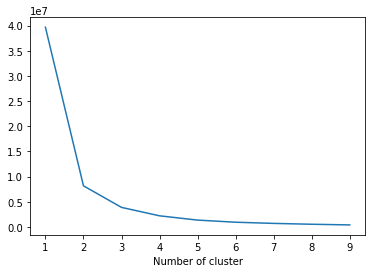

In [93]:
sse = {}
df_recency = df_user[['Recency']]
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,max_iter = 1000).fit(df_recency)
    df_recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

we're considering five cluster as post that decline is getting lesser. 4 could also be the choice though. It's more about experimenting.

In [94]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[["Recency"]])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

In [95]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_'+cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending = ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']],on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [96]:
df_user = order_cluster('RecencyCluster','Recency',df_user,False)

In [97]:
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,262.0,336.003817,27.182158,291.0,311.0,331.0,364.0,373.0
1,412.0,244.677184,25.973975,200.0,218.0,246.0,266.0,290.0
2,495.0,154.185859,25.940796,111.0,132.0,154.0,176.0,199.0
3,955.0,67.807330,18.275683,42.0,52.0,64.0,80.0,110.0
4,1826.0,15.693866,11.676129,0.0,6.0,14.0,24.0,41.0


4 means 1851 customers which purchased very recently. 

## Frequency

In [98]:
df_frequency = df_uk.groupby('CustomerID').InvoiceDate.count().reset_index()

In [99]:
df_frequency.columns = ['CustomerID','Frequency']

Adding this data for our main df_user

In [100]:
df_user= pd.merge(df_user, df_frequency,on='CustomerID')

In [101]:
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,13747.0,373,0,1
4,17908.0,373,0,58


In [102]:
plot_data= [
    go.Histogram(
    x=df_user.query('Frequency<1000')['Frequency']
    )
]
plot_layout = go.Layout(
        title = 'Frequency'
    )
fig=go.Figure(data=plot_data,layout=plot_layout)
pyoff.iplot(fig)

In [111]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[["Frequency"]])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

df_user = order_cluster('FrequencyCluster','Frequency',df_user,True)

df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3035.0,35.652389,28.167068,1.0,13.0,28.0,53.0,108.0
1,737.0,181.622795,61.159573,109.0,132.0,164.0,219.0,333.0
2,157.0,489.222930,133.207213,338.0,389.0,451.0,560.0,938.0
3,18.0,1403.111111,518.557375,977.0,1080.5,1162.5,1607.0,2782.0
4,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


## Revenue

In [104]:
df_uk['Revenue'] = df_uk['UnitPrice']*df_uk['Quantity']
df_revenue = df_uk.groupby('CustomerID').Revenue.sum().reset_index()

df_user = pd.merge(df_user,df_revenue,on='CustomerID')

plot_data = [
    go.Histogram(
        x=df_user.query('Revenue<10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout = plot_layout)
pyoff.iplot(fig)


Clustering the same as before

In [105]:
kmeans= KMeans(n_clusters = 4)
kmeans.fit(df_user[['Revenue']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['Revenue']])

df_user = order_cluster('RevenueCluster','Revenue',df_user,True)

df_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


In [106]:
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,0,312,2,5288.63,1
1,14688.0,7,4,359,2,5107.38,1
2,13767.0,1,4,399,2,16945.71,1
3,15513.0,30,4,314,2,14520.08,1
4,14849.0,21,4,392,2,7904.28,1


## Overall Score

In [107]:
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

C:\Users\Rachit Pahwa\AppData\Local\Temp\ipykernel_15752\4186553647.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
OverallScore,,,
0,336.372549,19.388235,254.482000
1,245.935961,23.399015,377.601650
2,156.350649,31.199134,567.439916
3,73.330085,39.228989,740.931306
4,24.475021,57.136325,963.798197
5,16.180233,163.641473,2257.339264
6,12.494505,316.956044,5673.874286
7,8.442105,450.157895,11115.049263
8,7.500000,990.136364,19699.675909


We can understand from the table above that 0 is the worst set of customers and 10 are the best set of customers. 
To keep things simple, let's name these scores.
0-2 : Low value
3-4 : Mid value
5+ : High value
we can easily apply in our dataframe

In [108]:
df_user['Segment'] = 'Low-value'
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-value'
df_user.loc[df_user['OverallScore']>4,'Segment'] = 'High-value'

Revenue vs Frequency

In [109]:
df_graph = df_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=df_graph.query("Segment=='Low-value'")['Frequency'],
        y=df_graph.query("Segment=='Low-value'")['Revenue'],
        mode='markers',
        name='Low',
        marker=dict(size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
            )
    ),
    go.Scatter(
    x=df_graph.query("Segment=='Mid-value'")['Frequency'],
    y=df_graph.query("Segment=='Mid-value'")['Revenue'],
    mode='markers',
    name='Mid',
    marker=dict(size=9,
        line=dict(width=1),
        color='green',
        opacity=0.5
        )
    ),
    go.Scatter(
    x=df_graph.query("Segment=='High-value'")['Frequency'],
    y=df_graph.query("Segment=='High-value'")['Revenue'],
    mode='markers',
    name='High',
    marker=dict(size=11,
        line=dict(width=1),
        color='red',
        opacity=0.9
        )
    ),
]

In [110]:
plot_layout = go.Layout(
        yaxis={'title':"Revenue"},
        xaxis={'title':'Frequency'},
        title = 'Segments'
    )
fig = go.Figure(data=plot_data,layout=plot_layout)
pyoff.iplot(fig)

We can strategize with this segmentation. The main strategies are clear:-

High Value: Improve Retention


Mid Value: Improve Retention + Increase Frequency

Low Value: Increase Frequency